# Plant Village

#### This notebook contains the code for data preprocessing of potato leaf images. The task is to classify these images into three (3) different classes namely: Early_blight, Late_blight and healthy. The model used for the classification task is a CNN. The model was built using Tensorflow framework.

#### Import the relevant libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [19]:
# Set some constant parameters

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [6]:
# Use tf.dataset to read in the 3 classes of images from the directory

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

In [13]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 0 0 1 2 1 0 1 0 1 0 0 1 1 0 0 0 0 1 1 2 0 1 0 0 0 2 0 1 0 0]


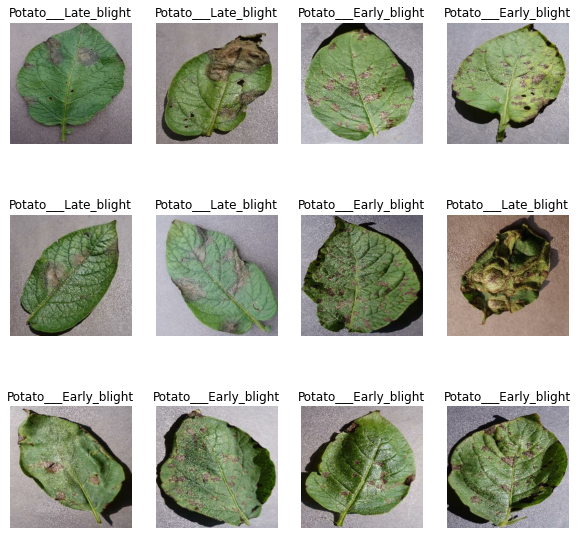

In [17]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [18]:
# Split dataset into train_test_split

In [23]:
train_size = 0.8
train_batch = round(len(dataset) * train_size)
train_ds = dataset.take(train_batch)
len(train_ds)

54

In [24]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [25]:
val_size = 0.1
val_batch = round(len(dataset) * val_size)
val_ds = test_ds.take(6)
len(val_ds)

6

In [26]:
test_ds = test_ds.skip(len(val_ds))
len(test_ds)

8

In [27]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=40)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [28]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [29]:
print("The length of train_ds is {}".format(len(train_ds)))
print("The length of val_ds is {}".format(len(val_ds)))
print("The length of test_ds is {}".format(len(test_ds)))

The length of train_ds is 54
The length of val_ds is 6
The length of test_ds is 8


In [31]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [34]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [37]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [39]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [40]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds
)

Epoch 1/50


/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


54/54 [==============================] - 55s 977ms/step - loss: 0.8927 - accuracy: 0.5053 - val_loss: 0.8413 - val_accuracy: 0.5052
Epoch 2/50
54/54 [==============================] - 52s 963ms/step - loss: 0.6567 - accuracy: 0.6913 - val_loss: 0.8148 - val_accuracy: 0.6771
Epoch 3/50
54/54 [==============================] - 52s 959ms/step - loss: 0.4904 - accuracy: 0.7934 - val_loss: 0.3973 - val_accuracy: 0.8125
Epoch 4/50
54/54 [==============================] - 55s 1s/step - loss: 0.2851 - accuracy: 0.8897 - val_loss: 0.2729 - val_accuracy: 0.8750
Epoch 5/50
54/54 [==============================] - 55s 1s/step - loss: 0.2384 - accuracy: 0.9114 - val_loss: 0.1810 - val_accuracy: 0.9271
Epoch 6/50
54/54 [==============================] - 55s 1s/step - loss: 0.1902 - accuracy: 0.9225 - val_loss: 0.2483 - val_accuracy: 0.8802
Epoch 7/50
54/54 [==============================] - 54s 1s/step - loss: 0.1361 - accuracy: 0.9577 - val_loss: 0.2858 - val_accuracy: 0.9010
Epoch 8/50
54/54 [====

In [41]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

First image to predict
The true label is Potato___Early_blight
Potato___Early_blight


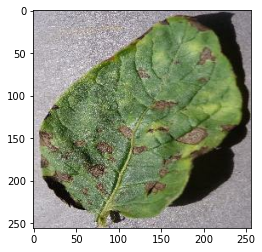

In [72]:
for image_batch, label_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print('First image to predict')
    plt.imshow(first_image)
    print('The true label is {}'.format(class_names[first_label]))
    
    predictions = model.predict(image_batch)
    
    print(class_names[np.argmax(predictions[0])])

In [57]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round (100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

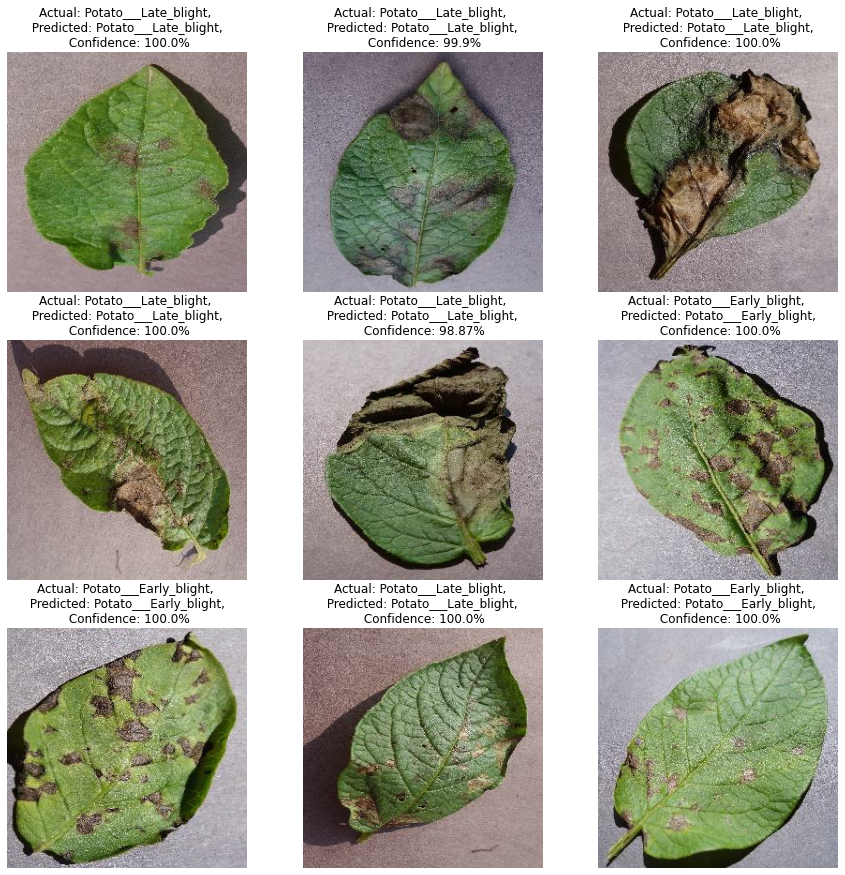

In [64]:
plt.figure(figsize=(15,15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i])
        
        actual_class = class_names[labels[i]]
        
        plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%')
        plt.axis('off')

In [101]:
import os
os.listdir('../models')
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}", save_format='h5')

ValueError: invalid literal for int() with base 10: '.DS_Store'